<a href="https://colab.research.google.com/github/fresilva-ai/public.ai/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import cv2
import imutils

import torch
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Paso 2: Montar Google Drive (donde están las imágenes)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT = "/content/drive/MyDrive/Fredy Silva O./2025/python/brain_tumor_detection/brain_mri/brain_tumor_dataset"
categories = ["no", "yes"]
IMG_ENDINGS = (".jpg", "jpeg", "JPG", "JPEG", "png", "PNG")

In [ ]:
class CropExtremePoints:
    def __init__(self, add_pixels_value=0):
        """
        Initialize the CropExtremePoints class.

            add_pixels_value (int): Number of pixels to expand the crop around the extreme points.
        """
        self.add_pixels_value = add_pixels_value

    def __call__(self, img) -> torch.tensor:
        """
        Perform the cropping operation.
            img (PIL Image, ndarray, or torch.Tensor): Input image.

        Returns:
            torch.Tensor: Cropped image.
        """
        # PIL image -> numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)

        # Tensor -> numpy array
        # (C, H, W) -> (H, W, C)
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()

        if isinstance(img, np.ndarray) and img.ndim == 3:
            ## Ensures 3 color channels
            if img.shape[2] != 3:
                raise ValueError("Image must have 3 channels (RGB).")

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            gray = cv2.GaussianBlur(gray, (5, 5), 0)

            # Threshold and remove noise
            thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
            thresh = cv2.erode(thresh, None, iterations=2)
            thresh = cv2.dilate(thresh, None, iterations=2)

            # Find contours
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            if not cnts:
                raise ValueError("No contours found in the image.")

            # Get the largest contour
            c = max(cnts, key=cv2.contourArea)

            # Find extreme points
            extLeft  = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop   = tuple(c[c[:, :, 1].argmin()][0])
            extBot   = tuple(c[c[:, :, 1].argmax()][0])

            # Apply cropping
            ADD_PIXELS = self.add_pixels_value
            cropped_img = img[
                max(0, extTop[1] - ADD_PIXELS):min(img.shape[0], extBot[1] + ADD_PIXELS),
                max(0, extLeft[0] - ADD_PIXELS):min(img.shape[1], extRight[0] + ADD_PIXELS)
            ]

            # Convert cropped image back to tensor
            # (H,W,C) -> (C, H, W)
            cropped_img = torch.from_numpy(cropped_img).permute(2, 0, 1)
            return cropped_img
        else:
            raise ValueError("Input image must be a 3D ndarray or a Tensor with 3 channels.")

In [ ]:
transformations = transforms.Compose([
    CropExtremePoints(add_pixels_value=0),
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees=6,
                            translate=(12/224, 12/224),
                            scale=(.75, 1.25),
                            shear=(2, 7, 3, 8)
                           ),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.05, 0.225)),
    transforms.ColorJitter(brightness=(.7, 1.5)),
    transforms.RandomRotation(6)
])

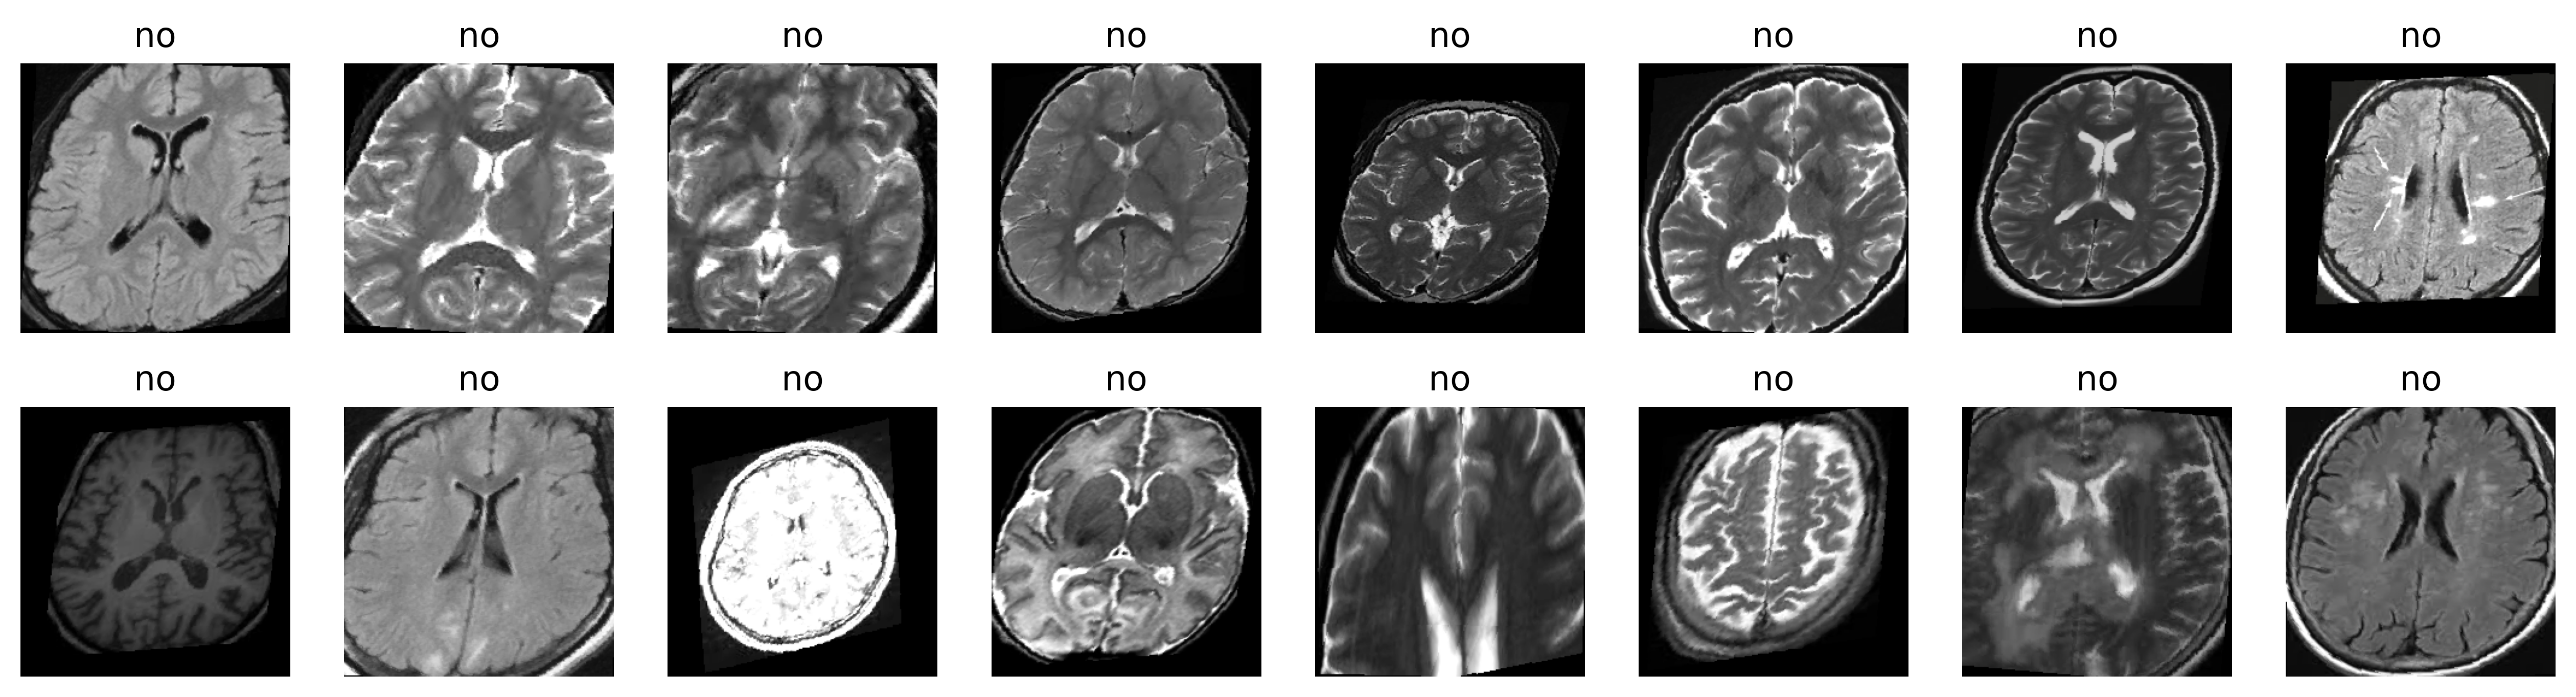

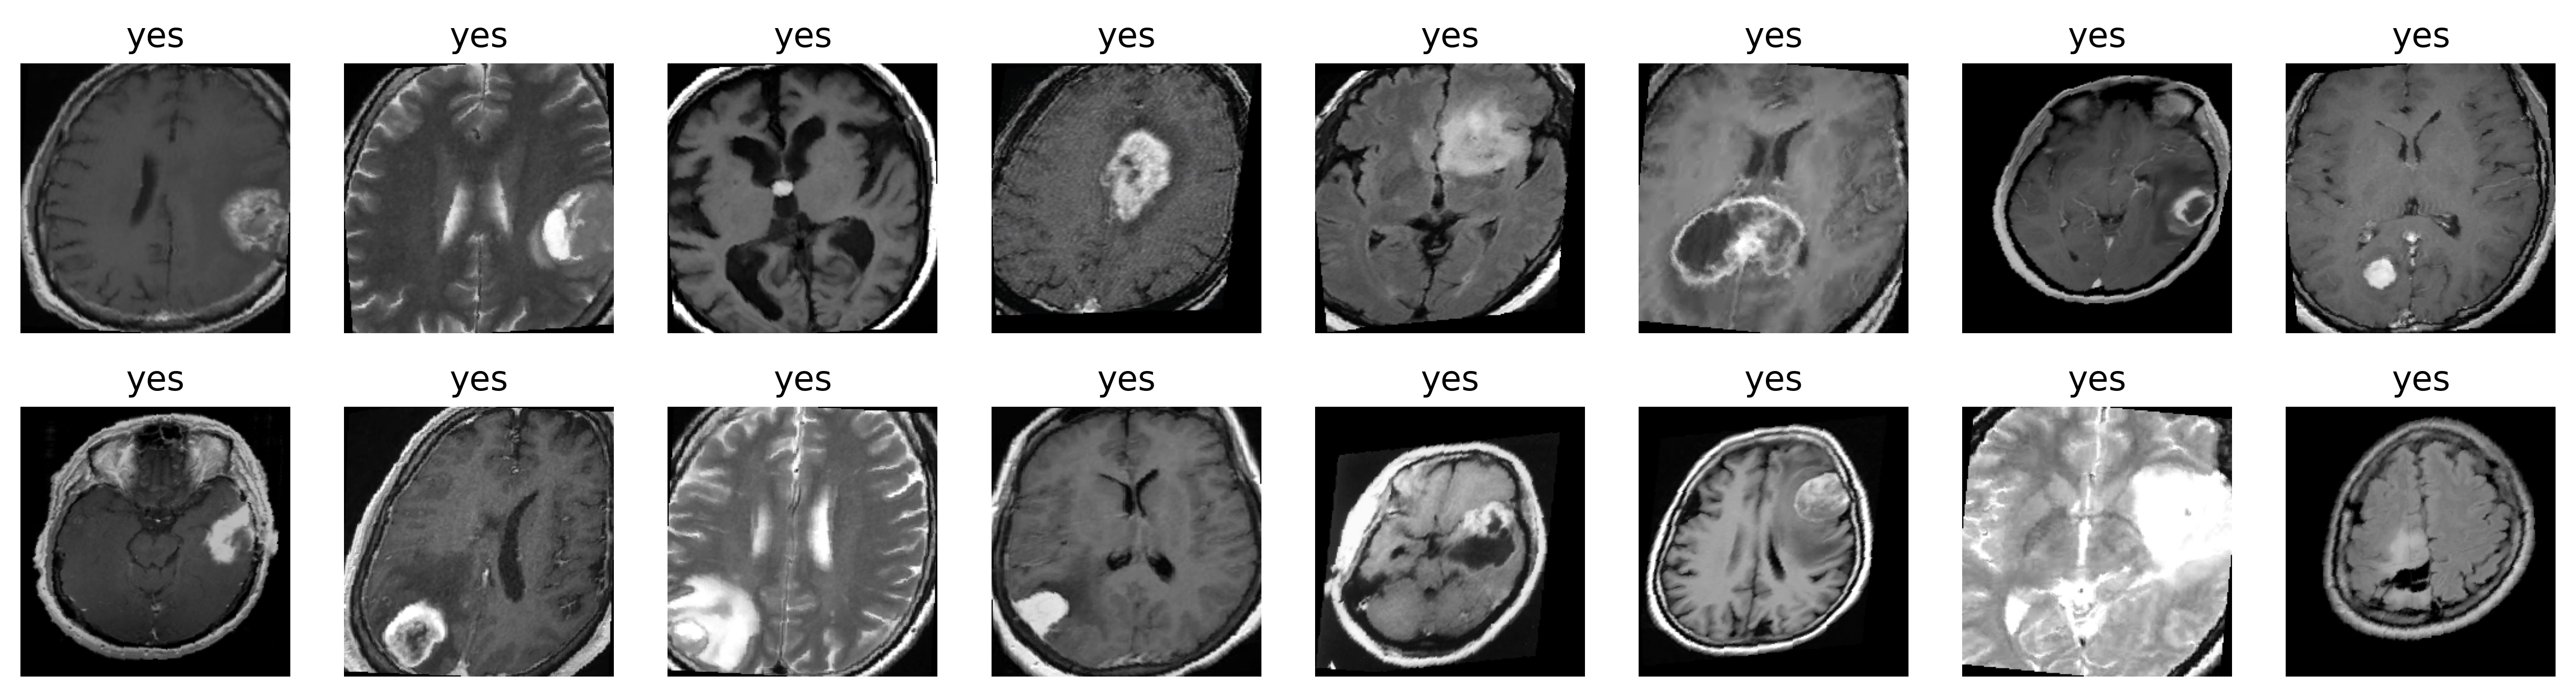

In [ ]:
for category in categories:
    category_path = os.path.join(ROOT, category)
    img_names = random.sample(os.listdir(category_path), 16)
    img_paths = [os.path.join(category_path, img_name) for img_name in img_names]

    plt.figure(figsize=(16,4), dpi=400)
    for k,img_path in enumerate(img_paths):
        plt.subplot(2, 8, k+1)
        img = Image.open(img_path).convert("RGB")
        img = transformations(img)
        plt.imshow(img)
        plt.axis("off")
        plt.title(category)
    plt.show()